By Leul Kifle

## 1. Project Overview

In this notebook I will explore the relationship between profanity in hip-hop lyrics and song popularity on Spotify, using data from 2020–2024. Unlike previous studies that used hate speech and focused across genres, my project:
- Focuses specifically on **profanity**, not hate speech
- Uses **recent streaming data**
- Analyzes only the **hip-hop genre**
- Uses a combination of **rule-based** and **contextual features** to score offensive language


## 2. Dataset Loading & Preview

- Source: [900K+ Spotify Songs with Lyrics, Emotions & More (Kaggle)](https://www.kaggle.com/datasets/devdope/900k-spotify)
- Created by: **DevDope**, Kaggle Novice from Mexico City  
  (*Master of Computer Science student at UAEMEX*)
- Filtered for hip-hop only
- Randomly selected 5,000 songs
- Includes fields like lyrics, artist, genre, popularity, etc.


### Step One: Download Dataset Using KaggleHub

In this step, I download the "900K+ Spotify Songs" dataset directly from Kaggle using the `kagglehub` library. This helps me to make sure that I have the latest version of the dataset stored locally for analysis. Then I moved it to the dataset directory.


In [1]:
import kagglehub

# The folloing code will make sure that the updated version is downloaded
path = kagglehub.dataset_download("devdope/900k-spotify")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\babyl\.cache\kagglehub\datasets\devdope\900k-spotify\versions\2


### Step Two: Import Libraries

In this section, I import all the main libraries used in the project. I might also add other libraries in the middle. However, these are the core ones.

- `pandas` & `numpy` for data manipulation  
- `matplotlib` & `seaborn` for visualizations  
- `nltk` for natural language processing tasks (tokenization, word filtering, etc.)  
- `re` (regular expressions) for advanced text cleaning and processing of song lyrics

Since this project focuses heavily on the lyrical content, I’ll rely on `nltk` and `re` throughout.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re


### Step three: Load the Dataset

Now let's load the CSV file into a pandas DataFrame. The file is stored in the same directory and named `spotify_dataset.csv`.


In [3]:
# The following code will load the dataset(ldata stands for lyrics data)
ldata = pd.read_csv("spotify_dataset.csv")
ldata.head()


,Artist(s),song,text,Length,emotion,Genre,Album,Release Date,Key,Tempo,...,Good for Morning Routine,Similar Artist 1,Similar Song 1,Similarity Score 1,Similar Artist 2,Similar Song 2,Similarity Score 2,Similar Artist 3,Similar Song 3,Similarity Score 3
0,!!!,Even When the Waters Cold,Friends told her she was better off at the bot...,03:47,sadness,hip hop,Thr!!!er,2013-04-29,D min,0.437870,...,0,Corey Smith,If I Could Do It Again,0.986061,Toby Keith,Drinks After Work,0.983719,Space,Neighbourhood,0.983236
1,!!!,One Girl / One Boy,"Well I heard it, playing soft From a drunken b...",04:03,sadness,hip hop,Thr!!!er,2013-04-29,A# min,0.508876,...,0,Hiroyuki Sawano,BRE@TH//LESS,0.995409,When In Rome,Heaven Knows,0.990905,Justice Crew,Everybody,0.984483
2,!!!,Pardon My Freedom,"Oh my god, did I just say that out loud? Shoul...",05:51,joy,hip hop,Louden Up Now,2004-06-08,A Maj,0.532544,...,0,Ricky Dillard,More Abundantly Medley Live,0.993176,Juliet,Avalon,0.965147,The Jacksons,Lovely One,0.956752
3,!!!,Ooo,[Verse 1] Remember when I called you on the te...,03:44,joy,hip hop,As If,2015-10-16,A min,0.538462,...,0,Eric Clapton,Man Overboard,0.992749,Roxette,Don't Believe In Accidents,0.991494,Tiwa Savage,My Darlin,0.990381
4,!!!,Freedom 15,[Verse 1] Calling me like I got something to s...,06:00,joy,hip hop,As If,2015-10-16,F min,0.544379,...,0,Cibo Matto,Lint Of Love,0.981610,Barrington Levy,Better Than Gold,0.981524,Freestyle,Its Automatic,0.981415


### Step four: Check the Dataset Structure

Let's get a summary of columns, data types, and missing values.


In [4]:
# General informantion about the dataset
ldata.info()

# Checking for missing values
ldata.isnull().sum()
ldata.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498052 entries, 0 to 498051
Data columns (total 39 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Artist(s)                       498052 non-null  object 
 1   song                            498038 non-null  object 
 2   text                            498052 non-null  object 
 3   Length                          498052 non-null  object 
 4   emotion                         498052 non-null  object 
 5   Genre                           498052 non-null  object 
 6   Album                           498003 non-null  object 
 7   Release Date                    350369 non-null  object 
 8   Key                             498052 non-null  object 
 9   Tempo                           498052 non-null  float64
 10  Loudness (db)                   498052 non-null  float64
 11  Time signature                  498044 non-null  object 
 12  Explicit        

,Tempo,Loudness (db),Popularity,Energy,Danceability,Positiveness,Speechiness,Liveness,Acousticness,Instrumentalness,...,Good for Relaxation/Meditation,Good for Exercise,Good for Running,Good for Yoga/Stretching,Good for Driving,Good for Social Gatherings,Good for Morning Routine,Similarity Score 1,Similarity Score 2,Similarity Score 3
count,498052.000000,498052.000000,498052.000000,498052.000000,498052.000000,498052.000000,498052.000000,498052.000000,498052.000000,498052.000000,...,498052.000000,498052.000000,498052.000000,498052.000000,498052.000000,498052.000000,498052.000000,498052.000000,498052.000000,498052.000000
mean,0.531244,0.762177,30.486453,62.744027,58.285191,47.067467,11.397157,19.787725,26.056827,7.361777,...,0.031744,0.184005,0.053199,0.022034,0.054735,0.009290,0.063618,0.982887,0.977765,0.974715
std,0.173153,0.072970,17.189269,22.688164,17.352930,24.091678,12.282150,16.310829,29.618874,20.736406,...,0.175317,0.387489,0.224431,0.146794,0.227463,0.095937,0.244071,0.013297,0.014951,0.015961
min,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,2.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002656,0.002647,0.002647
25%,0.390533,0.728743,19.000000,48.000000,46.000000,28.000000,4.000000,10.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.976614,0.970859,0.967244
50%,0.526627,0.777616,28.000000,65.000000,59.000000,46.000000,6.000000,13.000000,13.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.984911,0.980117,0.977254
75%,0.644970,0.811410,40.000000,81.000000,71.000000,66.000000,14.000000,25.000000,44.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.991553,0.987161,0.984789
max,1.000000,1.000000,100.000000,100.000000,99.000000,100.000000,97.000000,100.000000,100.000000,100.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# How many unique genres are in the dataset?
ldata['Genre'].unique()

array(['hip hop', 'jazz', 'indie rock,britpop', ...,
       'classical,heavy metal,ambient', 'chillout,ambient,house',
       'alternative,punk,rock'], dtype=object)

### Step five: Filter for Hip-Hop Genre

I filter the dataset to include only rows where the genre is labeled as "hip hop". This is pretty important for focusing the analysis on the genre relevant to my study.


In [6]:
# The following code will change genre column to lowercase (in case of mixed casing)
ldata['Genre'] = ldata['Genre'].str.lower()

# I will filter for hip hop genre only
# Filter rows where Genre is exactly 'hip hop' (case-insensitive)
hiphop_ldata = ldata[ldata['Genre'].str.strip().str.lower() == 'hip hop']


# Now let's see the output
hiphop_ldata.head()


,Artist(s),song,text,Length,emotion,Genre,Album,Release Date,Key,Tempo,...,Good for Morning Routine,Similar Artist 1,Similar Song 1,Similarity Score 1,Similar Artist 2,Similar Song 2,Similarity Score 2,Similar Artist 3,Similar Song 3,Similarity Score 3
0,!!!,Even When the Waters Cold,Friends told her she was better off at the bot...,03:47,sadness,hip hop,Thr!!!er,2013-04-29,D min,0.437870,...,0,Corey Smith,If I Could Do It Again,0.986061,Toby Keith,Drinks After Work,0.983719,Space,Neighbourhood,0.983236
1,!!!,One Girl / One Boy,"Well I heard it, playing soft From a drunken b...",04:03,sadness,hip hop,Thr!!!er,2013-04-29,A# min,0.508876,...,0,Hiroyuki Sawano,BRE@TH//LESS,0.995409,When In Rome,Heaven Knows,0.990905,Justice Crew,Everybody,0.984483
2,!!!,Pardon My Freedom,"Oh my god, did I just say that out loud? Shoul...",05:51,joy,hip hop,Louden Up Now,2004-06-08,A Maj,0.532544,...,0,Ricky Dillard,More Abundantly Medley Live,0.993176,Juliet,Avalon,0.965147,The Jacksons,Lovely One,0.956752
3,!!!,Ooo,[Verse 1] Remember when I called you on the te...,03:44,joy,hip hop,As If,2015-10-16,A min,0.538462,...,0,Eric Clapton,Man Overboard,0.992749,Roxette,Don't Believe In Accidents,0.991494,Tiwa Savage,My Darlin,0.990381
4,!!!,Freedom 15,[Verse 1] Calling me like I got something to s...,06:00,joy,hip hop,As If,2015-10-16,F min,0.544379,...,0,Cibo Matto,Lint Of Love,0.981610,Barrington Levy,Better Than Gold,0.981524,Freestyle,Its Automatic,0.981415


Here I'll check how many hip-hop songs I have after filtering.


In [7]:
# Number of hip hop songs
print(f"Total hip-hop tracks in the dataset: {hiphop_ldata.shape[0]}")


Total hip-hop tracks in the dataset: 210104


### Step six: Randomly Sample 5,000 Songs

I’ll randomly select 5,000 tracks to keep the rest of my task manageable while still having a strong sample size.


In [8]:
# First, let's set the seed 
sample_ldata = hiphop_ldata.sample(n=5000, random_state=42)

# Then we will reset the index
sample_ldata = sample_ldata.reset_index(drop=True)

# Finally let's see the output
sample_ldata.head()


,Artist(s),song,text,Length,emotion,Genre,Album,Release Date,Key,Tempo,...,Good for Morning Routine,Similar Artist 1,Similar Song 1,Similarity Score 1,Similar Artist 2,Similar Song 2,Similarity Score 2,Similar Artist 3,Similar Song 3,Similarity Score 3
0,Grieves,Levees,You're the weight of the water You're the weig...,02:24,sadness,hip hop,Running Wild,2017-08-25,D Maj,0.289941,...,0,"Taska Black,Aviella",In The End,0.974669,AJJ,American Tune,0.971818,Ylva,Hear You Sing,0.970130
1,Sage Francis,Rewrite,This is to the woman who I loved but lost Inte...,03:20,sadness,hip hop,Sick Of Waiting Tables,NaN,G Maj,0.408284,...,0,Carter Ace,Baggage,0.972308,Trip Lee,Beautiful Life 2 Mine,0.955699,"Mase,Diddy",Breathe Stretch Shake,0.955501
2,Mac Ayres,Shadows,[Verse 1] Tried to chase the storm but they sa...,03:09,joy,hip hop,Juicebox,2019-08-16,E min,0.295858,...,0,AK,Deja Vu,0.978723,TeaMarrr,The One,0.969745,SahBabii,Geico,0.957664
3,Maybird,Turning Into Water,I am turning into water My body is transformin...,03:21,anger,hip hop,Turning into Water,2016-04-29,G Maj,0.568047,...,0,The Slackers,Married Girl,0.981721,Bo Baskoro,Mercy,0.971744,Glee Cast,Do They Know Its Christmas?,0.966955
4,Paige,Make Room,[Verse 1] We can fight over the laundry but I'...,03:26,joy,hip hop,Always Growing EP,NaN,A Maj,0.242604,...,0,Plain White T's,Your Body,0.982335,"Jr., Harry Connick",This Christmas,0.980370,Keith Green,O God Our Lord,0.975255


In [27]:
# Save the sampled hip-hop dataset to a CSV file
sample_ldata.to_csv("spotifydataset.csv", index=False)


### Step seven: Filter for Core Features Only

Here I narrow the dataset down to just the essential features: lyrics, artist, genre, popularity, and song title (just for reference).


In [9]:
# Filter down the required features 
selected_columns = [
    'song',
    'Artist(s)',
    'text',
    'Genre',
    'Popularity'
]

# Here I'll create a DataFrame with selected features
filtered_ldata = sample_ldata[selected_columns].copy()

# Let's take a look at it
print(f'Table: \n {filtered_ldata.head()} \n \n Size: \n {filtered_ldata.shape}')


Table: 
                  song     Artist(s)  \
0              Levees       Grieves   
1             Rewrite  Sage Francis   
2             Shadows     Mac Ayres   
3  Turning Into Water       Maybird   
4           Make Room         Paige   

                                                text    Genre  Popularity  
0  You're the weight of the water You're the weig...  hip hop          13  
1  This is to the woman who I loved but lost Inte...  hip hop          13  
2  [Verse 1] Tried to chase the storm but they sa...  hip hop          26  
3  I am turning into water My body is transformin...  hip hop          32  
4  [Verse 1] We can fight over the laundry but I'...  hip hop          21   
 
 Size: 
 (5000, 5)


## 3. Data Cleaning

- Removed songs with missing lyrics or popularity
- Converted text to lowercase
- Removed section headers like [Chorus], [Verse]


### Step 1: Remove Songs with Missing Lyrics or Popularity

First I will drop any songs that are missing lyrics (`text` field) or popularity scores (`Popularity` field), because they are needed for the analysis.


In [10]:
# The following code will get rid of rows where 'text' (lyrics) or 'Popularity' is missing
filtered_ldata = filtered_ldata.dropna(subset=['text', 'Popularity'])

# Reset index after dropping
filtered_ldata = filtered_ldata.reset_index(drop=True)

# Preview
print(f'Table: \n {filtered_ldata.head()} \n \n Size: \n {filtered_ldata.shape}')


Table: 
                  song     Artist(s)  \
0              Levees       Grieves   
1             Rewrite  Sage Francis   
2             Shadows     Mac Ayres   
3  Turning Into Water       Maybird   
4           Make Room         Paige   

                                                text    Genre  Popularity  
0  You're the weight of the water You're the weig...  hip hop          13  
1  This is to the woman who I loved but lost Inte...  hip hop          13  
2  [Verse 1] Tried to chase the storm but they sa...  hip hop          26  
3  I am turning into water My body is transformin...  hip hop          32  
4  [Verse 1] We can fight over the laundry but I'...  hip hop          21   
 
 Size: 
 (5000, 5)


As we can see from the result there wasn't any missing data point.

### Step 2: Convert Lyrics Text to Lowercase


In [11]:
# Convert lyrics to lowercase
filtered_ldata['text'] = filtered_ldata['text'].str.lower()

# Let's check
filtered_ldata[['song', 'text']].head()


,song,text
0,Levees,you're the weight of the water you're the weig...
1,Rewrite,this is to the woman who i loved but lost inte...
2,Shadows,[verse 1] tried to chase the storm but they sa...
3,Turning Into Water,i am turning into water my body is transformin...
4,Make Room,[verse 1] we can fight over the laundry but i'...


### Step 3: Remove Section Headers Like [Chorus], [Verse]

I will remove annotations inside square brackets, such as [Chorus], [Verse 1], [Bridge], which are common in lyrics and not part of the actual sung words.
I will specifically use regular expressions (`re`) for this task.


In [12]:
# First I will define a regular expression cleaning function
def remove_bracket_tags(text):
    return re.sub(r'\[.*?\]', '', text)

# Then I will use the function to the 'text' feature
filtered_ldata['text'] = filtered_ldata['text'].apply(remove_bracket_tags)

# Let's see the cleaned lyrics
filtered_ldata[['song', 'text']].head()


,song,text
0,Levees,you're the weight of the water you're the weig...
1,Rewrite,this is to the woman who i loved but lost inte...
2,Shadows,tried to chase the storm but they said go bac...
3,Turning Into Water,i am turning into water my body is transformin...
4,Make Room,we can fight over the laundry but i'd be with...


## 4. Lyrics Preprocessing and Tokenization

### Plan for Text Preprocessing

In this section, I will prepare the cleaned lyrics text for profanity detection by following these steps:

| Step | What I Do                                   | Tools Used                        |
|------|----------------------------------------------|-----------------------------------|
| 4.1  | Tokenize the cleaned lyrics into words       | `nltk.word_tokenize()`            |
| 4.2  | Remove punctuation tokens                    | `string.punctuation`, `regex`     |
| 4.3  | Remove stopwords | Basic nltk filtering            |
| 4.4  | Prepare final cleaned tokens ready for profanity matching | Store into a new column (`tokens`) |

This preprocessing  shows that the lyrics are properly structured for accurate analysis when detecting offensive language.


### Step 1: Tokenize the Lyrics

In this step I will use `nltk.word_tokenize()` to split each lyric into individual words. This helps prepare for counting profanity words and doing further analysis.


In [13]:
from nltk.tokenize import word_tokenize

# Here I will do the same thing I did in the previous code that I will define a function and here to tokenize the text
def tokenize_lyrics(text):
    return word_tokenize(text)

# Then I will apply the function to the 'text' feature
filtered_ldata['tokens'] = filtered_ldata['text'].apply(tokenize_lyrics)
# Let's check the tokenization
filtered_ldata.head()


,song,Artist(s),text,Genre,Popularity,tokens
0,Levees,Grieves,you're the weight of the water you're the weig...,hip hop,13,"[you, 're, the, weight, of, the, water, you, '..."
1,Rewrite,Sage Francis,this is to the woman who i loved but lost inte...,hip hop,13,"[this, is, to, the, woman, who, i, loved, but,..."
2,Shadows,Mac Ayres,tried to chase the storm but they said go bac...,hip hop,26,"[tried, to, chase, the, storm, but, they, said..."
3,Turning Into Water,Maybird,i am turning into water my body is transformin...,hip hop,32,"[i, am, turning, into, water, my, body, is, tr..."
4,Make Room,Paige,we can fight over the laundry but i'd be with...,hip hop,21,"[we, can, fight, over, the, laundry, but, i, '..."


### Step 2: Remove Punctuation from Tokens

After tokenization, some tokens might just be punctuation marks (like ',', '.', '!', etc.). Let's remove them to keep only real words.


In [14]:
import string

# I will create a function to remove punctuation tokens
def remove_punctuation(tokens):
    return [word for word in tokens if word not in string.punctuation]

# Apply the function
filtered_ldata['tokens'] = filtered_ldata['tokens'].apply(remove_punctuation)

# Check
filtered_ldata.head()


,song,Artist(s),text,Genre,Popularity,tokens
0,Levees,Grieves,you're the weight of the water you're the weig...,hip hop,13,"[you, 're, the, weight, of, the, water, you, '..."
1,Rewrite,Sage Francis,this is to the woman who i loved but lost inte...,hip hop,13,"[this, is, to, the, woman, who, i, loved, but,..."
2,Shadows,Mac Ayres,tried to chase the storm but they said go bac...,hip hop,26,"[tried, to, chase, the, storm, but, they, said..."
3,Turning Into Water,Maybird,i am turning into water my body is transformin...,hip hop,32,"[i, am, turning, into, water, my, body, is, tr..."
4,Make Room,Paige,we can fight over the laundry but i'd be with...,hip hop,21,"[we, can, fight, over, the, laundry, but, i, '..."


### Step 3: Remove Stopwords

Instead of removing short words based on length, I will remove common stopwords like "the", "and", "in", "is", which actually don't have useful meaning for my analysis. 
This helps me focus only on the important words. 
Hence, I use NLTK’s built-in English stopword list for this step.


In [15]:
from nltk.corpus import stopwords

# I don't think I have stopwords so I will download it
nltk.download('stopwords')

# Then I will get English stopwords
stop_words = set(stopwords.words('english'))

# Here I will apply the same technique that I will define a function to remove stopwords from a list of tokens
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

# Let's use the function to the 'tokens' column
filtered_ldata['tokens'] = filtered_ldata['tokens'].apply(remove_stopwords)
# Check
filtered_ldata.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\babyl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,song,Artist(s),text,Genre,Popularity,tokens
0,Levees,Grieves,you're the weight of the water you're the weig...,hip hop,13,"['re, weight, water, 're, weight, water, n't, ..."
1,Rewrite,Sage Francis,this is to the woman who i loved but lost inte...,hip hop,13,"[woman, loved, lost, intertwined, souls, unive..."
2,Shadows,Mac Ayres,tried to chase the storm but they said go bac...,hip hop,26,"[tried, chase, storm, said, go, back, inside, ..."
3,Turning Into Water,Maybird,i am turning into water my body is transformin...,hip hop,32,"[turning, water, body, transforming, transluce..."
4,Make Room,Paige,we can fight over the laundry but i'd be with...,hip hop,21,"[fight, laundry, 'd, regardless, fly, vegas, s..."


Remove Leftover Contractions and Non-Word Tokens

After tokenizing and removing stopwords, some short contractions like `'d`, `n't`, and `'re` are still present in the tokens.  
These don't carry useful meaning for profanity or lyrical analysis, so I’ll filter them out.

I’ll remove any token that:
- Is just a contraction (like `'s`, `'re`, `'d`, `n't`)
- Is purely punctuation or a single quote-like character


In [16]:
# First let's efine known unwanted contraction tokens and single quote-like fragments
unwanted_tokens = {
    "'d", "n't", "'re", "'s", "'ll", "'ve", "'m",
    "’s", "’re", "‘", "’", "``", "''", "'", "`", "na", "ai"
}

# Then we will define function to clean up tokens
def clean_tokens(tokens):
    return [
        word for word in tokens
        if word.lower() not in unwanted_tokens #and len(word) > 2
    ]

# Finally we will apply the function to the 'tokens' feature
filtered_ldata['tokens'] = filtered_ldata['tokens'].apply(clean_tokens)

# Let's see the output
filtered_ldata.head()



,song,Artist(s),text,Genre,Popularity,tokens
0,Levees,Grieves,you're the weight of the water you're the weig...,hip hop,13,"[weight, water, weight, water, know, say, leve..."
1,Rewrite,Sage Francis,this is to the woman who i loved but lost inte...,hip hop,13,"[woman, loved, lost, intertwined, souls, unive..."
2,Shadows,Mac Ayres,tried to chase the storm but they said go bac...,hip hop,26,"[tried, chase, storm, said, go, back, inside, ..."
3,Turning Into Water,Maybird,i am turning into water my body is transformin...,hip hop,32,"[turning, water, body, transforming, transluce..."
4,Make Room,Paige,we can fight over the laundry but i'd be with...,hip hop,21,"[fight, laundry, regardless, fly, vegas, sign,..."


## 5. Profanity Detection and Scoring

Now that the lyrics have been tokenized and cleaned, so I'll analyze them for the presence of profanity.  
I use a rule-based method by matching tokens against a predefined list of profane words,  
which I loaded from an open-source GitHub repository.

The profanity list I used comes from the Google Profanity Words project maintained by [coffee-and-fun on GitHub](https://github.com/coffee-and-fun/google-profanity-words/blob/main/data/en.txt).

This step allows me to create a `profanity_count` feature for each song, which I will later use in my regression analysis.

---

### Plan for This Section:

| Step | What I Do                               | Tools Used                              |
|------|------------------------------------------|------------------------------------------|
| 5.1  | Load a profanity word list from GitHub   | Open-source dataset [`en.txt`](https://github.com/coffee-and-fun/google-profanity-words/blob/main/data/en.txt) |
| 5.2  | Count profanity words per song           | Python logic + `.apply()`                |
| 5.3  | Create new column: `profanity_count`     | `DataFrame.assign()`                     |
| 5.4  | Normalize profanity count (per 100 words) | Basic math                        |

This step is really needed for quantifying the level of offensive language in each song in a structured and replicable way.


### Step one: Load a Profanity Word List from GitHub

The file I pulled from the source and renamed as  `badwordsen.txt` contains hundreds of commonly recognized profane words, each on a separate line.  
I will convert the list into a Python set for fast matching for my analysis.


In [17]:
# First let's load the profanity list 

with open('badwords_en.txt', 'r') as file:
    profanity_words = file.read().splitlines()

# Then let's convert it to set for efficient lookup
profanity_set = set(profanity_words)

# let's look at the sample words like 10 of them.
print("Sample loaded profanity words:", list(profanity_set)[:10])


Sample loaded profanity words: ['mo-fo', 'bitcher', 'hooker', 'kooch', 'ball gravy', 'mothafucks', 'domination', 'shiz', 'ruski', 'g-spot']


### Step two: Count Profanity Words Per Song

In this step, we just count how many words in each song’s lyrics match the loaded profanity list.  
Here I will basically build a rule-based Python function across all tokenized lyrics to calculate a profanity score for every song.


In [18]:
# First I will define a function to count profane words in a list of tokens
def count_profanity(tokens):
    return sum(1 for word in tokens if word in profanity_set)

# Then here I will apply the function to each song's tokens
filtered_ldata['profanity_count'] = filtered_ldata['tokens'].apply(count_profanity)

# Let's take a look at the output
filtered_ldata[['song', 'profanity_count']].head()


,song,profanity_count
0,Levees,0
1,Rewrite,7
2,Shadows,1
3,Turning Into Water,0
4,Make Room,0


### Step three: Normalize Profanity Count

Since songs vary in total word count, so I will normalize the profanity count to show the number of profane words per 100 words.  
This allows fair comparison between short and long songs.

Formula:  
`normalized_profanity = (profanity_count / total_words) * 100`


In [19]:
# First Let's count the total number of words in each song (after cleaning)
filtered_ldata['total_word_count'] = filtered_ldata['tokens'].apply(len)

# Now we will calculate normalized profanity per 100 words
filtered_ldata['normalized_profanity'] = (filtered_ldata['profanity_count'] / filtered_ldata['total_word_count']) * 100

# Let's see the updated DataFrame
filtered_ldata[['song', 'profanity_count', 'total_word_count', 'normalized_profanity']].head()


,song,profanity_count,total_word_count,normalized_profanity
0,Levees,0,36,0.000000
1,Rewrite,7,258,2.713178
2,Shadows,1,171,0.584795
3,Turning Into Water,0,49,0.000000
4,Make Room,0,167,0.000000


## 6. Exploratory Data Analysis (EDA)

In this section, I will explore the cleaned dataset using basic visualizations and statistical summaries.  
The goal is to understand how profanity and popularity behave, both individually and together.

I will:
- Show the word cloud
- Show word frequency
- Visualize the distribution of profanity counts
- Visualize profanity vs. popularity
- Inspect the data further with a correlation matrix
- Compare popularity for high vs. low profanity songs
- Examine the relationship between normalized profanity and popularity


### Step one: Visualizing Common Words in Hip-Hop Lyrics

Before I get into the statistical analysis, it's helpful to visually explore the most common words in the lyrics.

In this step, I use two visuals:
- A **Word Cloud**, which highlights the most frequently used words in larger font.
- A **Word Frequency Bar Chart**, which shows the top 10 most common words and how often they appear.

These visualizations help reveal common themes, slang, or repeated expressions in the hip-hop genre.


In [20]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


Text(0.5, 1.0, 'Word Cloud of Hip-Hop Lyrics')

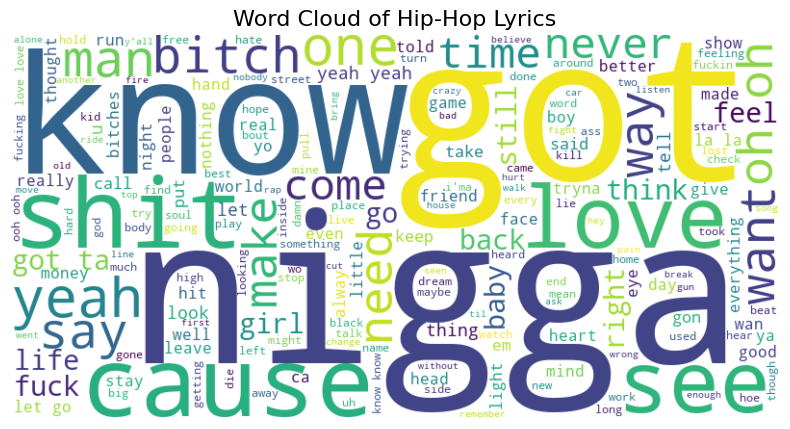

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Here I will first flatten the list of token lists into one long list of words
all_words = [word for tokens in filtered_ldata['tokens'] for word in tokens]

# Then I will generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))

# Let's see the wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Hip-Hop Lyrics', fontsize=16)


### Step Two: Visualizing Word Frequency

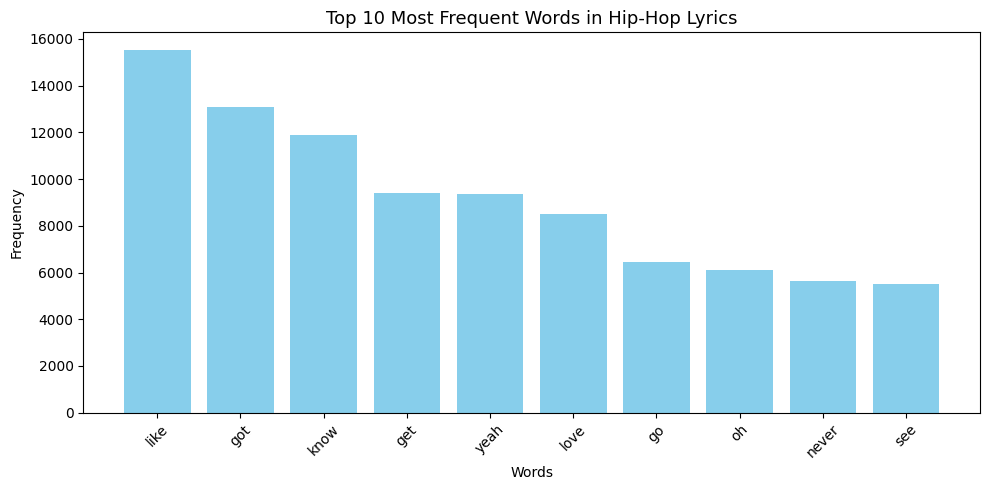

In [22]:
from collections import Counter

# Using the counter class from collections I will Count word frequencies
word_freq = Counter(all_words)
most_common = word_freq.most_common(10)

# Then the following code will separate words and counts
words, counts = zip(*most_common)

# Let's plot the bar chart
plt.figure(figsize=(10, 5))
plt.bar(words, counts, color='skyblue')
plt.title('Top 10 Most Frequent Words in Hip-Hop Lyrics', fontsize=13)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()



### Step Three: Distribution of Profanity Count

This plot shows how many songs contain low vs. high profanity counts.  
We use a histogram to visualize the distribution of `profanity_count` across all hip-hop tracks.


Text(0, 0.5, 'Number of Songs')

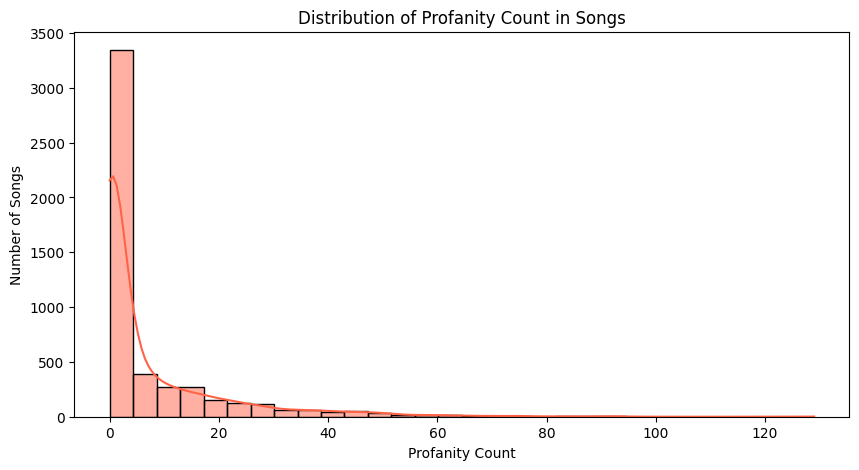

In [23]:
plt.figure(figsize=(10, 5))
sns.histplot(data=filtered_ldata, x='profanity_count', bins=30, kde=True, color='tomato')
plt.title('Distribution of Profanity Count in Songs')
plt.xlabel('Profanity Count')
plt.ylabel('Number of Songs')


### Step Four: Boxplot — Popularity: Profane vs. Clean Songs

Here I will split the songs into two groups: those with profanity and those without.  
Then I will compare the popularity scores across the two groups using a boxplot.


([<matplotlib.axis.XTick at 0x1f5274a74d0>,
 [Text(0, 0, 'No'), Text(1, 0, 'Yes')])

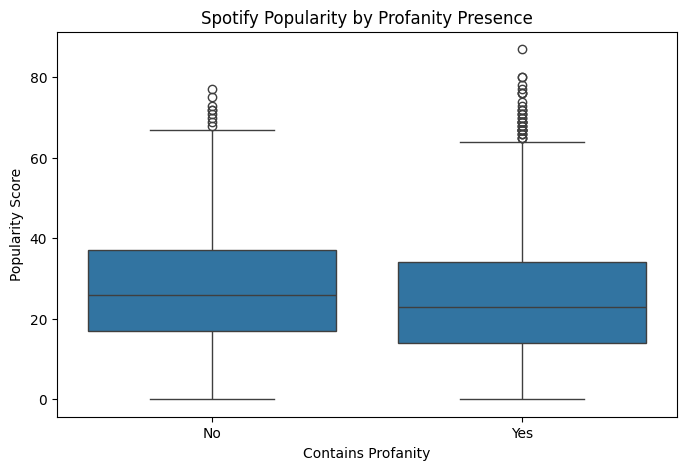

In [24]:
# To make it simple I will create binary column: True if profanity_count > 0, else False
filtered_ldata['has_profanity'] = filtered_ldata['profanity_count'] > 0

#let's see
plt.figure(figsize=(8, 5))
sns.boxplot(data=filtered_ldata, x='has_profanity', y='Popularity')
plt.title('Spotify Popularity by Profanity Presence')
plt.xlabel('Contains Profanity')
plt.ylabel('Popularity Score')
plt.xticks([0, 1], ['No', 'Yes'])


### Step Five: Correlation Heatmap

This heatmap will show us how the key numeric features like profanity count, normalized profanity, and total word count actually relate to thedependent variable: `Popularity`.


Text(0.5, 1.0, 'Correlation with Popularity')

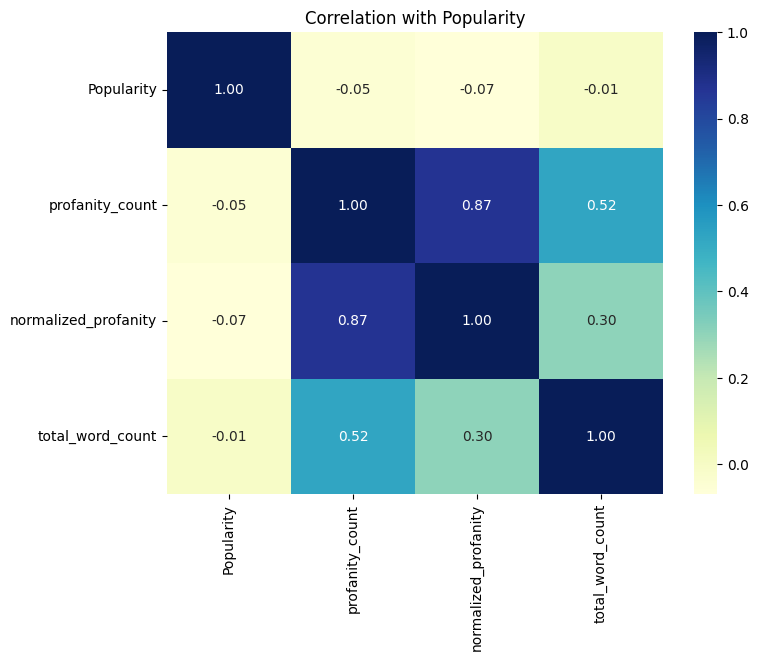

In [25]:
# First let's select relevant numeric columns
corr_features = ['Popularity', 'profanity_count', 'normalized_profanity', 'total_word_count']
corr_matrix = filtered_ldata[corr_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Correlation with Popularity')



### Step Six: Scatterplot Profanity Count vs. Popularity

Here I will plot profanity count against song popularity to observe any direct relationship.
This helps us visually assess whether more offensive songs tend to be more or less popular.



Text(0, 0.5, 'Popularity Score')

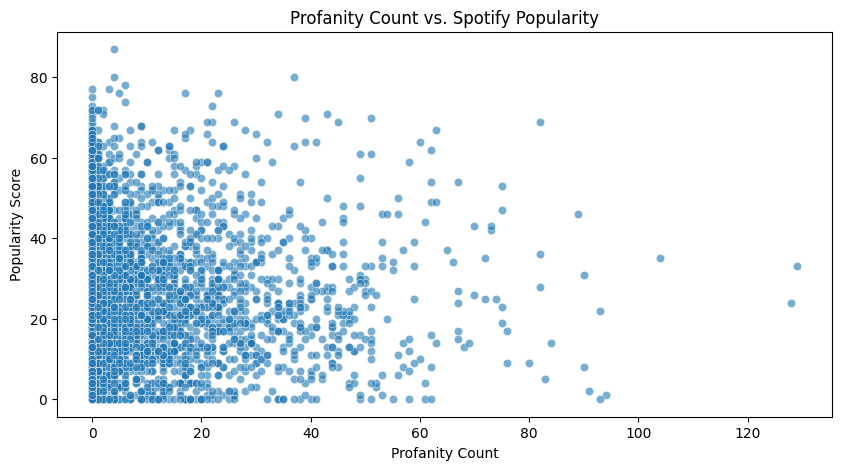

In [26]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=filtered_ldata, x='profanity_count', y='Popularity', alpha=0.6)
plt.title('Profanity Count vs. Spotify Popularity')
plt.xlabel('Profanity Count')
plt.ylabel('Popularity Score')



### Final Observation & Interpretation

After I inspect the above plot that shows the relationship between `normalized_profanity` and `Popularity` using a scatter plot, it became clear that there is **no visible pattern or meaningful trend**. As we can see from the plot that the data points are widely scattered, with no upward or downward slope that might suggest a relationship between profanity use and a song’s popularity score on Spotify.

Based on this visual evidence, and following a suggestion from my professor during my presentation, I decided **not to proceed with full regression modeling**. There appeared to be **no strong justification** for modeling since profanity does not seem to explain any significant variation in popularity. Any results from modeling at this point would likely be statistically insignificant or misleading.

For now, I will just **hold up the null hypothesis** that is, **there is no relationship between profanity in lyrics and Spotify popularity**. This remains my working conclusion unless future analysis is done using:
- Additional or stronger features (like artist name, genre variation, or follower count),
- A more advanced model for profanity detection (such as BERT or context-aware scoring), and
- A deeper look into how Spotify popularity scores are influenced by external factors.

This approach allows me to make a grounded, evidence-based conclusion without overfitting or forcing results that aren’t supported by the data.


## 8. Key Findings and Interpretation

### Final Takeaways

- My analysis suggests that **profanity is not a strong predictor of popularity** in hip-hop songs (at least in this sample).
- While in my hypothesis I assumed that more profanity might lead to more engagement or virality, the data does not support this.
- This contradicts some popular assumptions and shows that **other factors** (like artist fame, production, or social media trends) may matter more than lyrics alone.


### Limitations to Keep in Mind

- **Spotify popularity** is influenced by many hidden variables (e.g., playlisting, label marketing, algorithmic boosts).
- **Profanity detection** was rule-based and didn’t account for context or slang that might be interpreted differently.
- This is a correlational analysis not causation.

